In [10]:
pip install torch torchvision torchaudio scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [13]:
# Example: 80% train, 20% val
train_percent = 0.8

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  
                         [0.229, 0.224, 0.225]) 
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [14]:
dataset_path = "dataset" 

# Use ImageFolder to load images from subfolders
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=train_transform)

# Split into train and val
train_size = int(train_percent * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = data.random_split(full_dataset, [train_size, val_size])

# IMPORTANT: The val_dataset must use the val_transform 
# (rather than the train_transform) to avoid augmentation during validation.
val_dataset.dataset.transform = val_transform

# Data Loaders
batch_size = 32

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

# Class names
class_names = full_dataset.classes  # ['others', 'plastic_bottle'] in alphabetical order
print("Class names:", class_names)


Class names: ['others', 'plastic_bottle']


In [15]:
model = models.resnet50(weights='IMAGENET1K_V1') 

for param in model.parameters():
    param.requires_grad = False

# Replace the final FC layer
num_features = model.fc.in_features  
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 2) 
)

model = model.to(device)


In [16]:
for name, param in model.named_parameters():
    if "layer4" in name:  # layer4 is the last block in ResNet50
        param.requires_grad = True


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [18]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


In [19]:
import copy

num_epochs = 20
best_val_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())
train_losses, val_losses = [], []
train_accs, val_accs = [], []

patience = 5
wait = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        wait = 0  # reset patience
    else:
        wait += 1
    
    # Update scheduler if using
    if scheduler is not None:
        scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if wait >= patience:
        print("Early stopping triggered.")
        break

# Load best model
model.load_state_dict(best_model_weights)


Epoch [1/20] Train Loss: 0.1871, Train Acc: 0.9328 Val Loss: 0.0439, Val Acc: 0.9862
Epoch [2/20] Train Loss: 0.0253, Train Acc: 0.9940 Val Loss: 0.0755, Val Acc: 0.9655
Epoch [3/20] Train Loss: 0.0109, Train Acc: 0.9966 Val Loss: 0.0546, Val Acc: 0.9759
Epoch [4/20] Train Loss: 0.0079, Train Acc: 0.9983 Val Loss: 0.0678, Val Acc: 0.9759
Epoch [5/20] Train Loss: 0.0040, Train Acc: 0.9983 Val Loss: 0.0609, Val Acc: 0.9862
Epoch [6/20] Train Loss: 0.0043, Train Acc: 0.9991 Val Loss: 0.0583, Val Acc: 0.9931
Epoch [7/20] Train Loss: 0.0028, Train Acc: 1.0000 Val Loss: 0.0515, Val Acc: 0.9931
Epoch [8/20] Train Loss: 0.0023, Train Acc: 1.0000 Val Loss: 0.0530, Val Acc: 0.9931
Epoch [9/20] Train Loss: 0.0021, Train Acc: 1.0000 Val Loss: 0.0569, Val Acc: 0.9897
Epoch [10/20] Train Loss: 0.0012, Train Acc: 1.0000 Val Loss: 0.0530, Val Acc: 0.9897
Epoch [11/20] Train Loss: 0.0015, Train Acc: 1.0000 Val Loss: 0.0557, Val Acc: 0.9897
Early stopping triggered.


<All keys matched successfully>

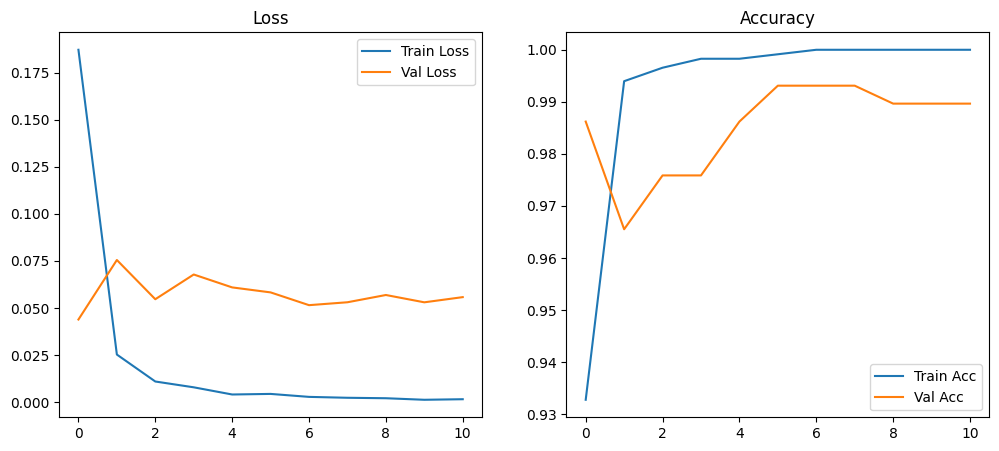

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()


In [21]:
# Evaluate final model
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
print(f"Final Val Loss: {val_loss:.4f}, Final Val Acc: {val_acc:.4f}")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Final Val Loss: 0.0583, Final Val Acc: 0.9931
Confusion Matrix:
 [[140   0]
 [  2 148]]

Classification Report:
                precision    recall  f1-score   support

        others       0.99      1.00      0.99       140
plastic_bottle       1.00      0.99      0.99       150

      accuracy                           0.99       290
     macro avg       0.99      0.99      0.99       290
  weighted avg       0.99      0.99      0.99       290



In [22]:
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        # Copy all layers except the final fc
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)      
        x = torch.flatten(x, 1)    
        return x

feature_extractor = ResNet50FeatureExtractor(model)
feature_extractor.to(device)
feature_extractor.eval()


ResNet50FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [23]:
def extract_features(dataloader, feature_extractor):
    all_feats = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)  # shape [batch_size, 2048]
            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())
    
    all_feats = np.concatenate(all_feats, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_feats, all_labels

train_feats, train_labels = extract_features(train_loader, feature_extractor)
val_feats,   val_labels   = extract_features(val_loader,   feature_extractor)

print("Train feats:", train_feats.shape)
print("Val feats:", val_feats.shape)


Train feats: (1160, 2048)
Val feats: (290, 2048)


In [24]:
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(train_feats, train_labels)

svm_val_acc = svm_clf.score(val_feats, val_labels)
print(f"SVM Accuracy: {svm_val_acc:.4f}")

svm_preds = svm_clf.predict(val_feats)
print("SVM Confusion Matrix:\n", confusion_matrix(val_labels, svm_preds))
print("\nSVM Classification Report:")
print(classification_report(val_labels, svm_preds, target_names=class_names))


SVM Accuracy: 0.9897
SVM Confusion Matrix:
 [[140   0]
 [  3 147]]

SVM Classification Report:
                precision    recall  f1-score   support

        others       0.98      1.00      0.99       140
plastic_bottle       1.00      0.98      0.99       150

      accuracy                           0.99       290
     macro avg       0.99      0.99      0.99       290
  weighted avg       0.99      0.99      0.99       290



In [25]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(train_feats, train_labels)

rf_val_acc = rf_clf.score(val_feats, val_labels)
print(f"RF Accuracy: {rf_val_acc:.4f}")

rf_preds = rf_clf.predict(val_feats)
print("Random Forest Confusion Matrix:\n", confusion_matrix(val_labels, rf_preds))
print("\nRandom Forest Classification Report:")
print(classification_report(val_labels, rf_preds, target_names=class_names))


RF Accuracy: 0.9828
Random Forest Confusion Matrix:
 [[140   0]
 [  5 145]]

Random Forest Classification Report:
                precision    recall  f1-score   support

        others       0.97      1.00      0.98       140
plastic_bottle       1.00      0.97      0.98       150

      accuracy                           0.98       290
     macro avg       0.98      0.98      0.98       290
  weighted avg       0.98      0.98      0.98       290



In [26]:
import torch

# Save the best model weights
torch.save(best_model_weights, "best_model_weights.pth")

In [37]:
from PIL import Image
import torchvision.transforms as transforms


infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

def predict_image(model, image_path, device, class_names):
    model.eval()  
    
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Apply transformations
    img_t = infer_transform(img)
    img_t = img_t.unsqueeze(0) 
    img_t = img_t.to(device)

    with torch.no_grad():
        outputs = model(img_t) 
        _, preds = torch.max(outputs, 1)
        predicted_class_idx = preds.item()
    
    predicted_class = class_names[predicted_class_idx]
    return predicted_class

# Example usage:
unseen_image_path = "test/p1.jpeg"
pred_class = predict_image(model, unseen_image_path, device, class_names=["others","plastic_bottle"])
print("Predicted class:", pred_class)


Predicted class: plastic_bottle
